<a href="https://colab.research.google.com/github/Jamess200/MyBirdNetTest/blob/main/HistogramAndAccuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd
import plotly.graph_objects as go
import os
import plotly.express as px
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

In [3]:
# Define path in Google Drive where you want to clone the repository
repo_path = '/content/drive/MyDrive/'

# Check if directory already exists
if not os.path.exists(repo_path):
    os.makedirs(repo_path)

# Change working directory to defined path
os.chdir(repo_path)

# Clone the repository if doesnt exist, otherwise pull latest changes
if not os.path.exists(os.path.join(repo_path, 'MyBirdNetTest')):
    !git clone https://github.com/Jamess200/MyBirdNetTest.git
else:
    os.chdir('MyBirdNetTest')
    !git pull

# Verify cloned repository
!ls

remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 6.58 KiB | 2.00 KiB/s, done.
From https://github.com/Jamess200/MyBirdNetTest
   8ffdf04..b171c83  main       -> origin/main
Updating e310bf8..b171c83
error: The following untracked working tree files would be overwritten by merge:
	data/CSV_data/BirdNET_results7.csv
	data/CSV_data/BirdNET_results8.csv
	data/CSV_data/combined.csv
Please move or remove them before you merge.
Aborting
data			 img		       json_to_csv_converter.ipynb  Time_Test_BN_Test.ipynb
Density_plot_code.ipynb  Inital_BN_Test.ipynb  README.md


In [4]:
cd /content/drive/MyDrive/MyBirdNetTest/data/CSV_data

/content/drive/MyDrive/MyBirdNetTest/data/CSV_data


In [5]:
#@title Data Loading and Preprocessing
# Read the combined CSV file
data = pd.read_csv('combined.csv')

# Ensure 'date' column is in datetime format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Create a 'count' column filled with 1s to represent one detection per row
data['count'] = 1

In [10]:
#@title Data Aggregation and Filtering
# Filter species with more than 20 detections
species_counts = data['common_name'].value_counts().reset_index()
species_counts.columns = ['common_name', 'count']
filtered_species_counts = species_counts[species_counts['count'] > 20]

# Get top and bottom 3 species
top_3_species = filtered_species_counts.nlargest(3, 'count')['common_name']
bottom_3_species = filtered_species_counts.nsmallest(3, 'count')['common_name']

# Data for top and bottom 3 species
top_3_data = data[data['common_name'].isin(top_3_species)]
bottom_3_data = data[data['common_name'].isin(bottom_3_species)]
combined_data = pd.concat([top_3_data, bottom_3_data])


In [11]:
#@title  Pearson Correlation Coefficient Analysis and Visualisation For Top & Bottom 3 Species
# Calculate metrics for top and bottom species
# Calculate counts and rename the 'index' column to 'common_name'
counts_df = combined_data['common_name'].value_counts().reset_index().rename(columns={'index': 'common_name', 0: 'count'})

# Calculate average confidence and rename the 'confidence' column to 'average_confidence'
confidence_df = combined_data.groupby('common_name')['confidence'].mean().reset_index().rename(columns={'confidence': 'average_confidence'})

# Merge the two DataFrames on 'common_name'
top_bottom_metrics = pd.merge(counts_df, confidence_df, on='common_name')

# Calculate the correlation
correlation = top_bottom_metrics['count'].corr(top_bottom_metrics['average_confidence'])
interpretation = "positive" if correlation > 0 else "negative"
print(f"Correlation between number of detections and average confidence: {correlation:.3f}")
print(f"There is a {interpretation} correlation between the number of detections and the average confidence.")

# Extract x and y values for plotting
x = top_bottom_metrics['count']
y = top_bottom_metrics['average_confidence']

# Calculate best-fit line
m, b = np.polyfit(x, y, 1)

# Create a scatter plot with Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers+text',
    text=top_bottom_metrics['common_name'],
    textposition='top center',
    marker=dict(size=10, color='lightblue', line=dict(color='black', width=1))
))

# Add best-fit line to the plot
fig.add_trace(go.Scatter(
    x=x,
    y=m*x + b,
    mode='lines',
    name='Best fit line',
    line=dict(color='blue')
))

# Update layout of the plot
fig.update_layout(
    title='Correlation between Number of Detections and Average Confidence (Top 3 and Bottom 3 Species)',
    xaxis_title='Number of Detections',
    yaxis_title='Average Confidence',
    height=600
)

# Show the plot
fig.show()

Correlation between number of detections and average confidence: 0.972
There is a positive correlation between the number of detections and the average confidence.


In [96]:
#@title ANOVA Analysis and Visualisation For Top & Bottom 3 Species
# Perform ANOVA
anova_result = f_oneway(
    combined_data[combined_data['common_name'] == top_3_species.iloc[0]]['confidence'],
    combined_data[combined_data['common_name'] == top_3_species.iloc[1]]['confidence'],
    combined_data[combined_data['common_name'] == top_3_species.iloc[2]]['confidence'],
    combined_data[combined_data['common_name'] == bottom_3_species.iloc[0]]['confidence'],
    combined_data[combined_data['common_name'] == bottom_3_species.iloc[1]]['confidence'],
    combined_data[combined_data['common_name'] == bottom_3_species.iloc[2]]['confidence']
)

anova_f_statistic = round(anova_result.statistic, 3)
anova_p_value = format(anova_result.pvalue, '.4g')
interpretation = "statistically significant" if anova_result.pvalue < 0.05 else "not statistically significant"
print(f"ANOVA F-statistic: {anova_f_statistic}, p-value: {anova_p_value}")
print(f"This ANOVA test indicates that there are {interpretation} differences in the confidence scores among the top 3 and bottom 3 species.")

# Box plot
fig_box = px.box(
    combined_data, x='common_name', y='confidence',
    title='Box Plot of Confidence Scores for Top 3 and Bottom 3 Species',
    labels={'confidence': 'Confidence Score', 'common_name': 'Species'},
    color_discrete_sequence=['blue'], points=False, height=600
)
fig_box.update_layout(xaxis_title="Species", yaxis_title="Confidence Score")
fig_box.show()

ANOVA F-statistic: 285.153, p-value: 2.625e-298
This ANOVA test indicates that there are statistically significant differences in the confidence scores among the top 3 and bottom 3 species.


In [97]:
#@title Histogram Visualisation
# Histogram of confidence scores
fig_histogram = px.histogram(
    data, x='confidence',
    title='Histogram of Total Accuracy on All Predictions',
    labels={'confidence': 'Confidence Score'},
    nbins=40, color_discrete_sequence=['blue']
)
fig_histogram.update_traces(xbins=dict(start=0.25, end=1.0, size=0.03))
fig_histogram.update_layout(
    xaxis=dict(range=[0.25, 1.0], tickvals=np.arange(0.25, 1.01, 0.03), ticktext=[f'{x:.2f}' for x in np.arange(0.25, 1.01, 0.03)]),
    xaxis_title="Confidence Score", yaxis_title="Count", bargap=0.075
)
fig_histogram.show()

In [79]:
#@title Species Richness
# Average species richness per day
species_per_day = data.groupby('date')['common_name'].nunique().reset_index()
species_per_day.columns = ['date', 'unique_species_count']
average_species_richness = species_per_day['unique_species_count'].mean()
print(f"Average species richness per day: {average_species_richness:.2f}")
print(species_per_day)

Average species richness per day: 72.33
        date  unique_species_count
0 2024-05-02                    77
1 2024-05-03                    66
2 2024-05-04                    74
3 2024-05-05                    73
4 2024-05-06                    70
5 2024-05-07                    69
6 2024-05-08                    72
7 2024-05-09                    71
8 2024-05-10                    79


In [99]:
#@title  Pearson Correlation Coefficient Analysis and Visualisation For All Species
# Calculate metrics for all species with more than 20 detections
all_species_metrics = pd.merge(
    filtered_species_counts,
    data.groupby('common_name')['confidence'].mean().reset_index().rename(columns={'confidence': 'average_confidence'}),
    on='common_name'
)

# Calculate the correlation
correlation = all_species_metrics['count'].corr(all_species_metrics['average_confidence'])
interpretation = "positive" if correlation > 0 else "negative"
print(f"Correlation between number of detections and average confidence: {correlation:.3f}")
print(f"There is a {interpretation} correlation between the number of detections and the average confidence.")

# Extract x and y values for plotting
x = all_species_metrics['count']
y = all_species_metrics['average_confidence']

# Calculate best-fit line
m, b = np.polyfit(x, y, 1)

# Create a scatter plot with Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    text=all_species_metrics['common_name'],
    textposition='top center',
    marker=dict(size=10, color='lightblue', line=dict(color='black', width=1))
))

# Add best-fit line to the plot
fig.add_trace(go.Scatter(
    x=x,
    y=m*x + b,
    mode='lines',
    name='Best fit line',
    line=dict(color='blue')
))

# Update layout of the plot
fig.update_layout(
    title='Correlation between Number of Detections and Average Confidence (All Species)',
    xaxis_title='Number of Detections',
    yaxis_title='Average Confidence',
    height=600
)

# Show the plot
fig.show()

Correlation between number of detections and average confidence: 0.392
There is a positive correlation between the number of detections and the average confidence.


In [100]:
#@title  Bar Plot Visualisations
# Bar plots for frequency of calls and average accuracy by species
fig_frequency = go.Figure()
fig_frequency.add_trace(go.Bar(
    y=all_species_metrics['common_name'], x=all_species_metrics['count'],
    name='Frequency of Calls', orientation='h', marker=dict(color='blue')
))
fig_frequency.update_layout(
    title='Frequency of Calls by Species', xaxis_title='Frequency of Calls', yaxis_title='Species', height=2000, yaxis=dict(automargin=True)
)
fig_frequency.show()

fig_accuracy = go.Figure()
fig_accuracy.add_trace(go.Bar(
    y=all_species_metrics['common_name'], x=all_species_metrics['average_confidence'],
    name='Average Accuracy', orientation='h', marker=dict(color='orange')
))
fig_accuracy.update_layout(
    title='Average Accuracy by Species', xaxis_title='Average Accuracy', yaxis_title='Species', height=2000, yaxis=dict(automargin=True)
)
fig_accuracy.show()

In [102]:
#@title Additional Analysis and Visualisation for Selected Species

# Specify the bird species to show
selected_species_list = ['Lesser Whitethroat', 'Willow Warbler', 'Common Buzzard', 'Eurasian Skylark',
                         'Spotted Flycatcher', 'Eurasian Treecreeper', 'European Goldfinch', 'European Robin',
                         'Eurasian Blackbird', 'Carrion Crow', 'Barn Owl', 'Goldcrest', 'Red Kite', 'Eurasian Wren',
                         'Common Wood-Pigeon', 'Common Chiffchaff', 'Rook']

# Filter the data for the specified species
filtered_data = data[data['common_name'].isin(selected_species_list)]

# Calculate the average confidence for each species
average_confidence_Specific = filtered_data.groupby('common_name')['confidence'].mean().reset_index()
average_confidence_Specific.columns = ['common_name', 'average_confidence_Specific']

# Calculate the number of detections for each species
detection_counts = filtered_data['common_name'].value_counts().reset_index()
detection_counts.columns = ['common_name', 'count']

# Merge the average confidence and detection counts
correlation_data = pd.merge(detection_counts, average_confidence_Specific, on='common_name')

# Calculate the correlation
correlation = correlation_data['count'].corr(correlation_data['average_confidence_Specific'])
print(f"Correlation between number of detections and average confidence: {correlation:.3f}")

# Interpretation
if correlation > 0:
    interpretation = "There is a positive correlation between the number of detections and the average confidence."
else:
    interpretation = "There is a negative correlation between the number of detections and the average confidence."

print(interpretation)

# Plot the data for visualization
x = correlation_data['count']
y = correlation_data['average_confidence_Specific']
m, b = np.polyfit(x, y, 1)

fig_cor = go.Figure()

fig_cor.add_trace(go.Scatter(
    x=correlation_data['count'],
    y=correlation_data['average_confidence_Specific'],
    mode='markers',
    text=correlation_data['common_name'],
    textposition='top center',
    marker=dict(size=10, color='lightblue', line=dict(color='black', width=1)),
))

# Add best-fit line
fig_cor.add_trace(go.Scatter(
    x=x,
    y=m*x + b,
    mode='lines',
    name='Best fit line',
    line=dict(color='blue')
))

fig_cor.update_layout(
    title='Correlation between Number of Detections and Average Confidence (Selected Species)',
    xaxis_title='Number of Detections',
    yaxis_title='Average Confidence',
    height=600,
)

# Show the Plot
fig_cor.show()


Correlation between number of detections and average confidence: 0.740
There is a positive correlation between the number of detections and the average confidence.


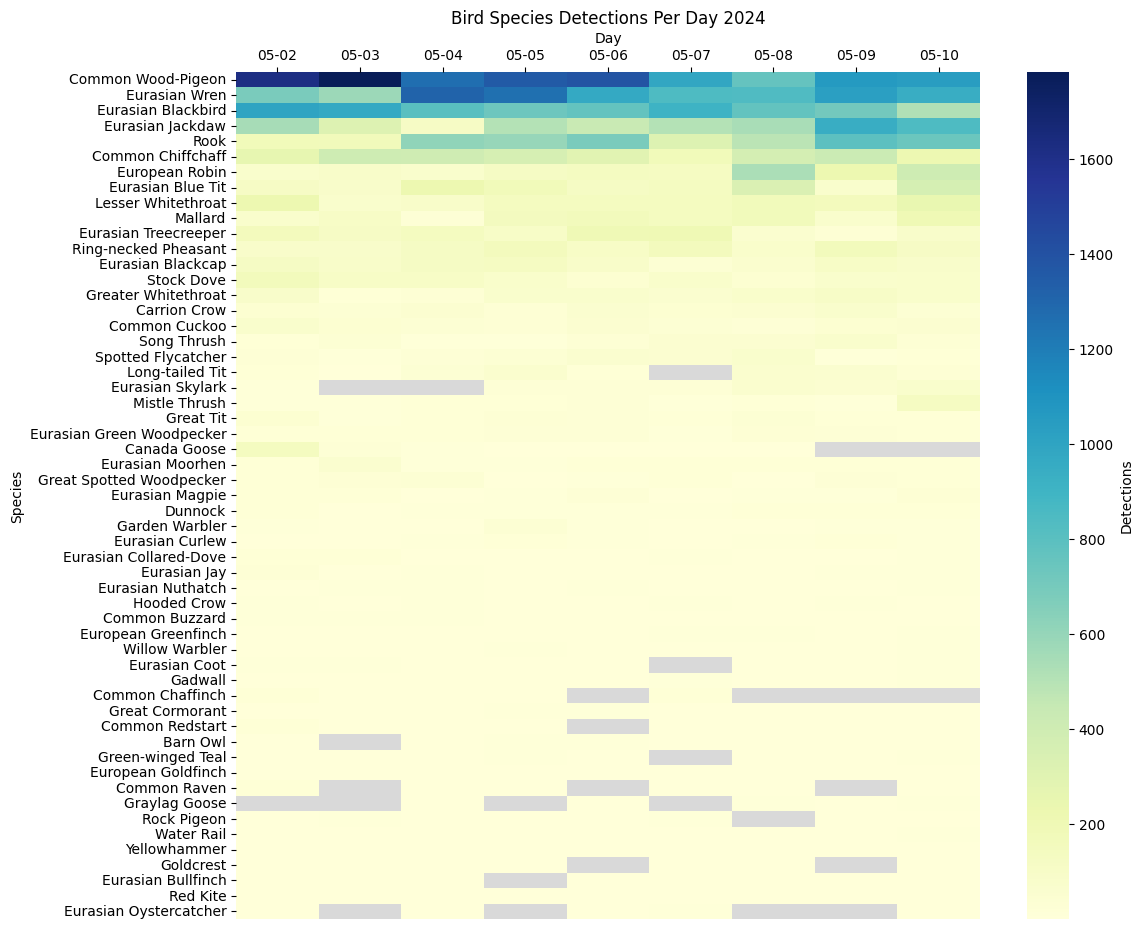

In [103]:
# Ensure 'date' column is in datetime format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

# Create a 'count' column filled with 1s to represent one detection per row
data['count'] = 1

# Extract date (without time) from the 'date' column
data['day'] = data['date'].dt.date

# Format the day column to only include month and day
# Convert 'day' column to datetime objects before using .dt accessor
data['day'] = pd.to_datetime(data['day']).dt.strftime('%m-%d')

# Aggregate the data to count the detections for each bird
species_counts = data.groupby('common_name')['count'].sum()

# Filter out birds with fewer than 20 detections
filtered_species = species_counts[species_counts >= 20].index
filtered_data = data[data['common_name'].isin(filtered_species)]

# Create a pivot table to prepare data for the heatmap, use 'common_name' instead of 'species'
pivot_data = filtered_data.pivot_table(index='common_name', columns='day', values='count', aggfunc='sum', fill_value=0)

# Sum the counts for each species and sort in descending order
sorted_species = pivot_data.sum(axis=1).sort_values(ascending=False).index

# Reorder the rows of the DataFrame
pivot_data = pivot_data.loc[sorted_species]

# Create a larger figure to accommodate the plot
plt.figure(figsize=(12, len(pivot_data.index) * 0.2))  # Adjust the size as needed

# Create a colormap that uses gray for zero detections
cmap = colors.ListedColormap(sns.color_palette("YlGnBu", 256))
cmap.set_under((0.85, 0.85, 0.85))  # Light gray

# Create the heatmap
sns.heatmap(pivot_data, cmap=cmap, vmin=0.01, cbar_kws={'label': 'Detections'})  # Set vmin to a small value so that zero detections are colored gray

plt.title('Bird Species Detections Per Day 2024')
plt.ylabel('Species')
plt.xlabel('Day')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability and adjust alignment

# Move the x-axis labels to the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.show()

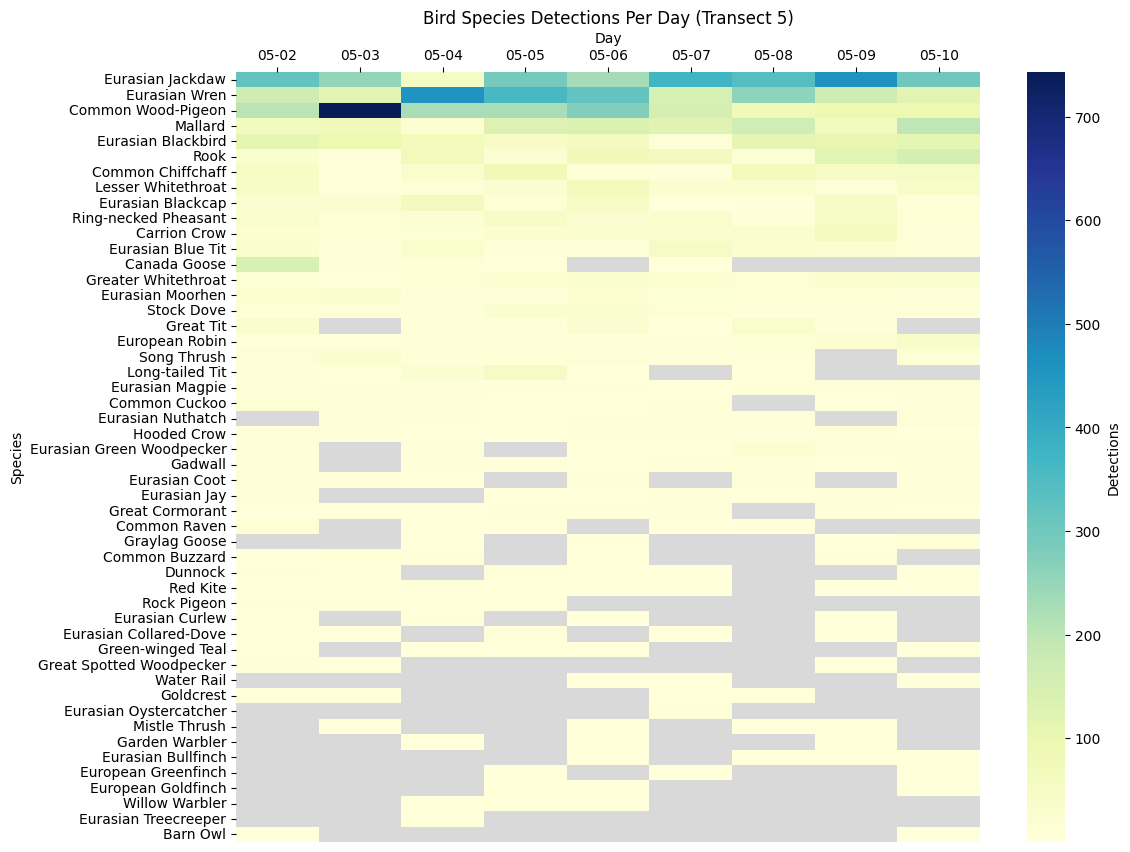

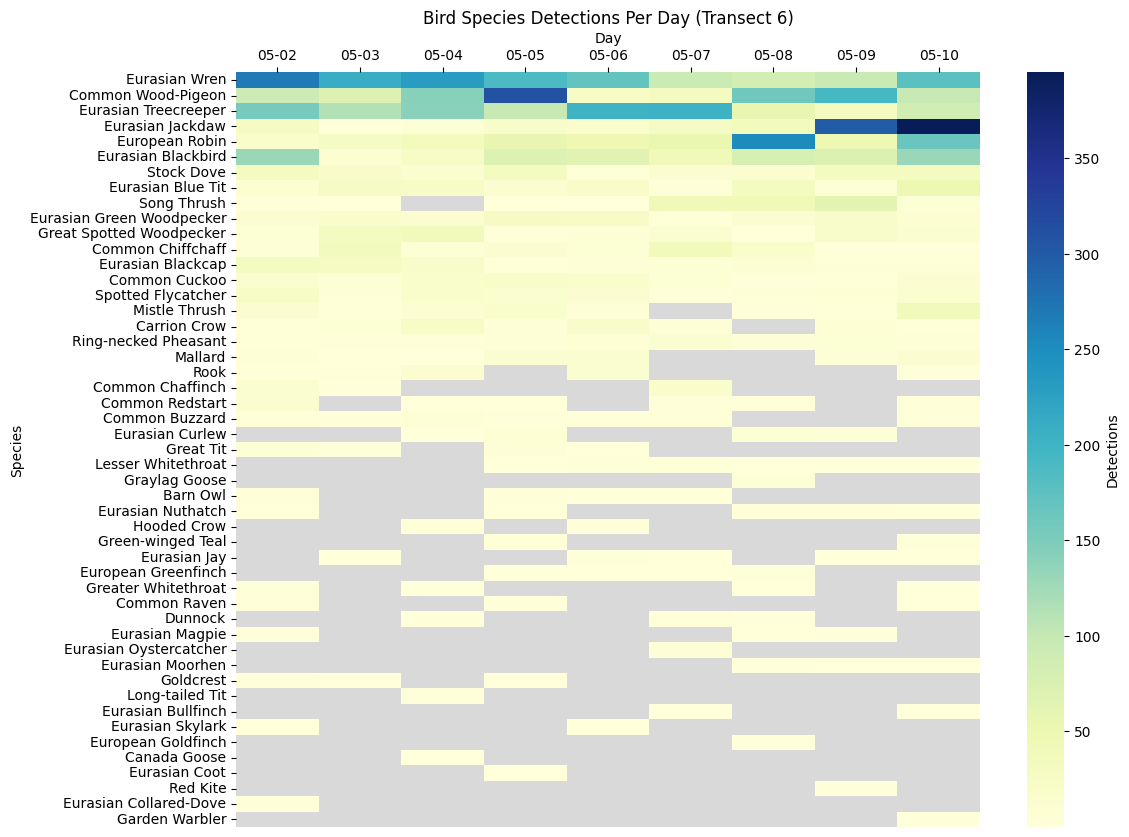

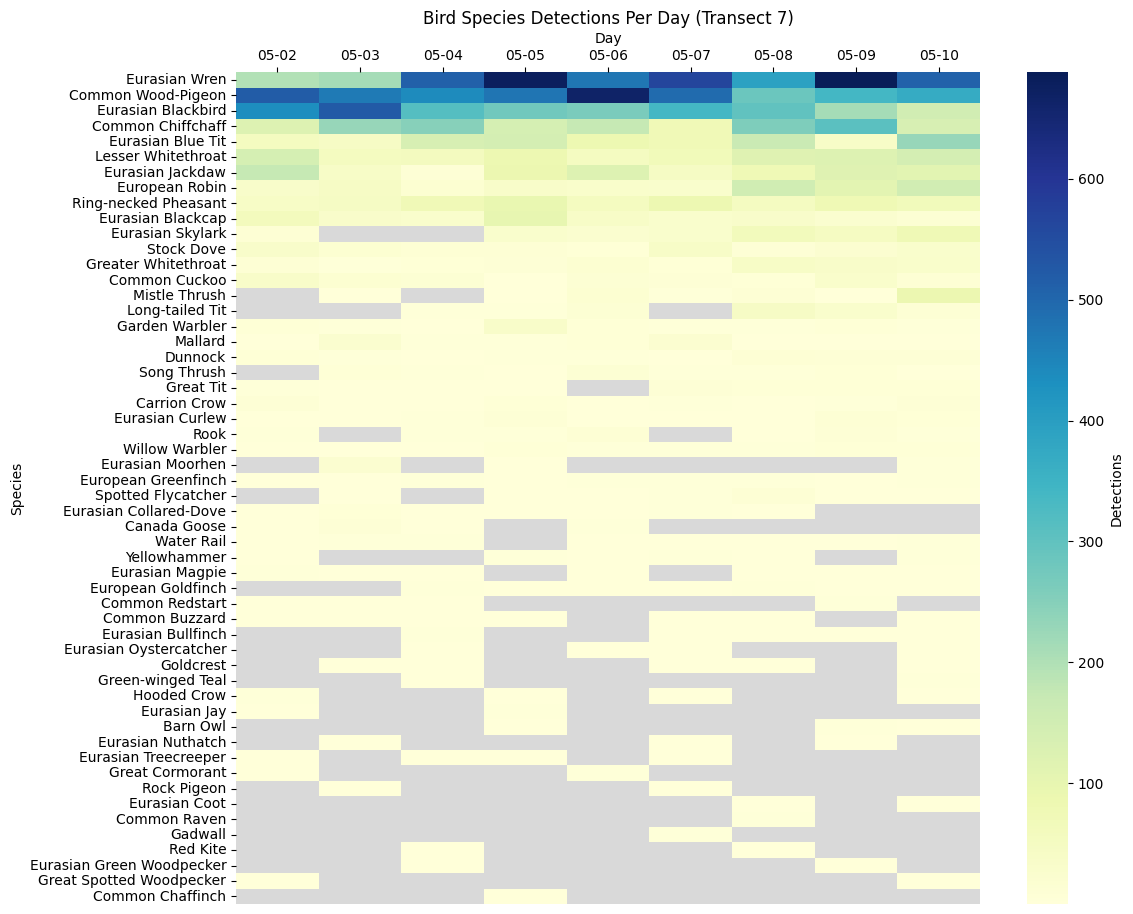

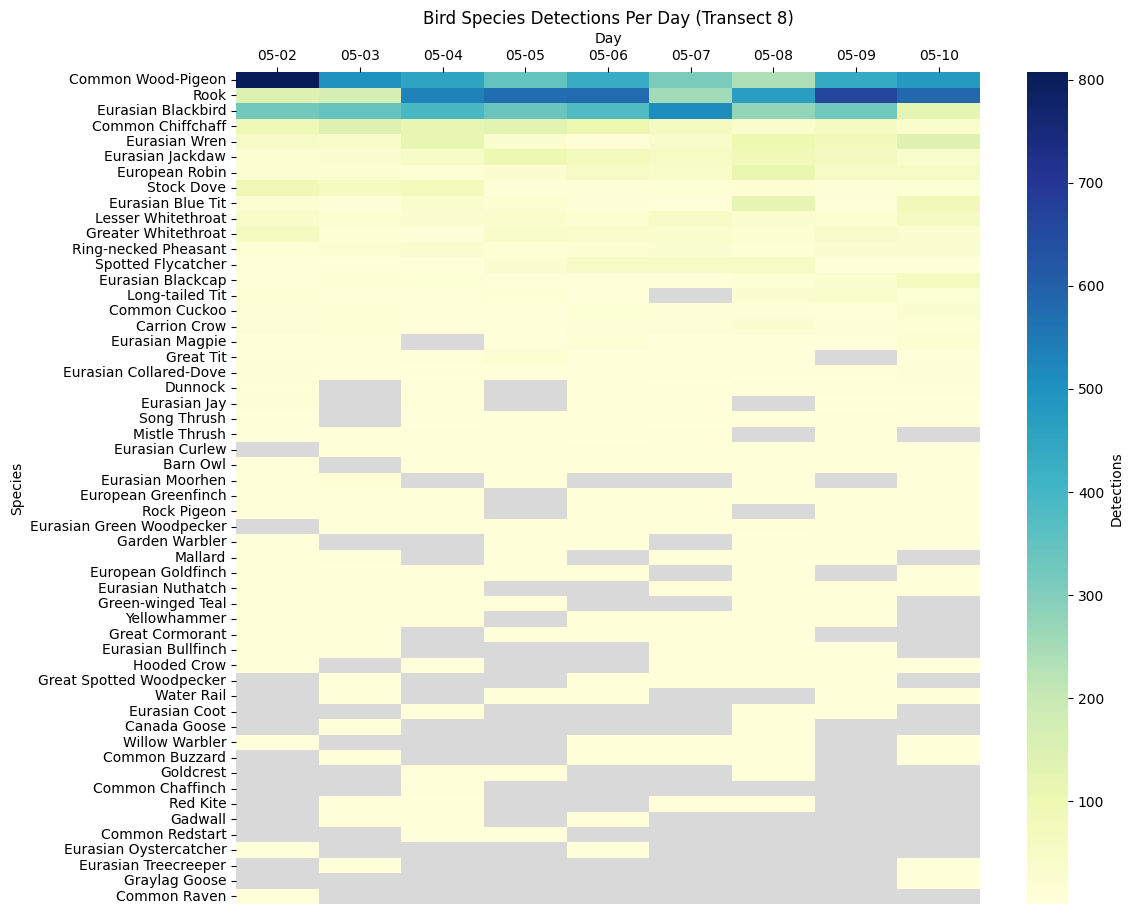

In [104]:
# List of transects
transects = filtered_data['transect'].unique()

# Create a heatmap for each transect
for transect in transects:
    transect_data = filtered_data[filtered_data['transect'] == transect]

    # Create a pivot table to prepare data for the heatmap
    pivot_data = transect_data.pivot_table(index='common_name', columns='day', values='count', aggfunc='sum', fill_value=0)

    # Sum the counts for each species and sort in descending order
    sorted_species = pivot_data.sum(axis=1).sort_values(ascending=False).index

    # Reorder the rows of the DataFrame
    pivot_data = pivot_data.loc[sorted_species]

    # Create a larger figure to accommodate the plot
    plt.figure(figsize=(12, len(pivot_data.index) * 0.2))  # Adjust the size as needed

    # Create a colormap that uses gray for zero detections
    cmap = colors.ListedColormap(sns.color_palette("YlGnBu", 256))
    cmap.set_under((0.85, 0.85, 0.85))  # Light gray

    # Create the heatmap
    sns.heatmap(pivot_data, cmap=cmap, vmin=0.01, cbar_kws={'label': 'Detections'})  # Set vmin to a small value so that zero detections are colored gray

    plt.title(f'Bird Species Detections Per Day (Transect {transect})')
    plt.ylabel('Species')
    plt.xlabel('Day')
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability and adjust alignment

    # Move the x-axis labels to the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    # Show the plot
    plt.show()